Author: Zidong Chen

Date:2024/07/04

Introduction

With the advancement of hardware technology, leveraging GPUs for parallel computing in Gaussian processes has become a prominent question. After significant progress in developing scalable GP models, I am excited to introduce a new inference method for standard Gaussian processes that enables GPU acceleration. This method allows for training exact Gaussian processes with thousands of data points in seconds, using just a single GPU on a laptop.


In [1]:
import os
import time
import sys

sys.path.append('..')  # Add parent folder to sys.path

import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from data_sample import generate_example_data as data
from core.cigp_baseline import cigp
# from torch.autograd import Variable
import torch.optim as optim
from core.kernel import ARDKernel

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # Fixing strange error if run in MacOS
JITTER = 1e-3
EPS = 1e-10
PI = 3.1416
torch.set_default_dtype(torch.float64)

In standard Gaussian process, the negative log likelihood is given by:
$$-L=\frac{1}{2}y^T\Sigma^{-1}y+\frac{1}{2}log(|\Sigma|)+\frac{n}{2}log(2\pi)$$
Where$\Sigma = K(X,X)+ \frac{1}{\beta} I$, normally we compute the inverse of $\Sigma$ using Cholesky decomposition, which requires $O(n^3)$ time complexity. Here we use the conjugate gradient method to solve the linear system $\Sigma \cdot x = y$, which gives us x=$\Sigma^{-1} \cdot y$. The [conjugate gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method) is an iterative method, which is more suitable for large-scale data. And the time complexity is $O(n^2 t_\epsilon)$ with $t_\epsilon$ equals to the number of iterations required for the algorithm to converge to a solution within a tolerance level $\epsilon$, and $t_\epsilon \ll n$ for large $n$.


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def conjugate_gradient(A, b, x0=None, tol=1e-1, max_iter=1000):
    if x0 is None:
        x = torch.zeros_like(b)
    else:
        x = x0
    r = b - torch.matmul(A, x)
    p = r.clone()
    rsold = torch.dot(r.flatten(), r.flatten())

    for i in range(max_iter):
        Ap = torch.matmul(A, p)
        alpha = rsold / torch.dot(p.flatten(), Ap.flatten())
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = torch.dot(r.flatten(), r.flatten())

        if torch.sqrt(rsnew) < tol:
            break

        p = r + (rsnew / rsold) * p
        rsold = rsnew

        #if i % 10 == 0:  # Print diagnostics every 10 iterations
        #print(f"Iteration {i}: Residual norm {torch.sqrt(rsnew):.6e}")

    return x


def cholesky_solve(A, b):
    # Perform Cholesky decomposition (A = LL^T)
    L = torch.linalg.cholesky(A)

    # Solve Ax = b using torch.cholesky_solve
    x = torch.cholesky_solve(b, L)

    return x


# Verify the solutions
def verify_solution(A, b, x):
    residual = b - torch.matmul(A, x)
    residual_norm = torch.norm(residual)
    return residual_norm

In [3]:
# generate example data
xtr, ytr, xte, yte = data.generate(2000, 100, seed=42)
xtr = xtr.to(dtype=torch.float64, device=device)
ytr = ytr.to(dtype=torch.float64, device=device)
xte = xte.to(dtype=torch.float64, device=device)

In [4]:
kernel = ARDKernel(1)
log_beta = nn.Parameter(torch.ones(1, dtype=torch.float64, device=device) * 0)
# this is a large noise. we optimize to shrink it to a proper value.

Let us compare the performance of using conjugate_gradient and cholesky decomposition to solve the linear system $\Sigma \cdot x=y$

In [5]:
Sigma = kernel(xtr, xtr) + torch.eye(xtr.size(0), device=device) * torch.exp(log_beta) + JITTER * torch.eye(xtr.size(0),
                                                                                                            device=device)


In [6]:
start_time = time.time()
x_cg = conjugate_gradient(Sigma, ytr)
time_cg = time.time() - start_time
print(f"Conjugate Gradient Solution Time: {time_cg:.6f} seconds")

Conjugate Gradient Solution Time: 0.007002 seconds


In [8]:
start_time = time.time()
x_cholesky = cholesky_solve(Sigma, ytr)
time_cholesky = time.time() - start_time
print(f"Cholesky Solution Time: {time_cholesky:.6f} seconds")

Cholesky Solution Time: 0.215119 seconds


In [9]:
residual_norm_cg = verify_solution(Sigma, ytr, x_cg)
residual_norm_cholesky = verify_solution(Sigma, ytr, x_cholesky)
print(f"Conjugate Gradient Residual Norm: {residual_norm_cg:.6e}")
print(f"Cholesky Residual Norm: {residual_norm_cholesky:.6e}")

Conjugate Gradient Residual Norm: 7.077787e-03
Cholesky Residual Norm: 6.066984e-12


As we can see from the above results, the Conjugate Gradient method solves the linear system much faster than Cholesky decomposition with acceptable accuracy. Users can set a smaller tolerance for better accuracy, but due to floating-point errors, this is often unnecessary. The next challenge is to solve for the log determinant of the covariance matrix, here we propose a numerically stable version of [Lanczos algorithm for quadratic forms](https://shashankaubaru.github.io/Papers/Lanc_Quad.pdf).

In [10]:
import torch


def lanc_quad_logdet(A, m=10, nvecs=10):
    """
    Estimate the log-determinant of a symmetric positive definite matrix using
    the Stochastic Lanczos Quadrature (SLQ) method.

    Parameters:
    A (torch.Tensor): The symmetric positive definite input matrix.
    m (int): Number of Lanczos steps (degree).
    nvecs (int): Number of starting vectors.

    Returns:
    z1 mean: The average of estimates for starting vectors.
    """
    n = A.shape[0]
    z1 = torch.zeros(nvecs, dtype=A.dtype, device=A.device)

    for ii in range(nvecs):
        w = torch.sign(torch.randn(n, dtype=A.dtype, device=A.device))  # Random Rademacher vector
        v0 = w / torch.norm(w)
        #print(torch.norm(w))
        # Lanczos algorithm
        V = torch.zeros((n, m), dtype=A.dtype, device=A.device)
        alpha = torch.zeros(m, dtype=A.dtype, device=A.device)
        beta = torch.zeros(m - 1, dtype=A.dtype, device=A.device)
        V[:, 0] = v0.clone()

        w = A @ V[:, 0].clone()
        #print(A)
        alpha[0] = torch.dot(V[:, 0].clone(), w)
        w = w - alpha[0].clone() * V[:, 0].clone()

        for j in range(1, m):
            beta[j - 1] = torch.norm(w)
            if beta[j - 1] != 0:
                V[:, j] = w / beta[j - 1].clone()
                w = A @ V[:, j].clone() - beta[j - 1].clone() * V[:, j - 1].clone()
                alpha[j] = torch.dot(V[:, j].clone(), w)
                w = w - alpha[j].clone() * V[:, j].clone()

        H = torch.diag(alpha) + torch.diag(beta, 1) + torch.diag(beta, -1)
        #print(V[:, j])
        #print(w)
        #print(torch.diag(alpha),torch.diag(beta, 1),torch.diag(beta, -1))
        #print(H)
        eigvals, eigvecs = torch.linalg.eig(H)
        eigvals, eigvecs = eigvals.real, eigvecs.real
        #print(eigvals)
        theta = torch.abs(eigvals)
        gamma2 = eigvecs[0, :] ** 2

        # Sum of gamma2 * log(theta)
        count = torch.sum(gamma2 * torch.log(theta))
        z1[ii] = (count * n).real

    return z1.mean()


In [16]:
start_time = time.time()
log_det_lanc = lanc_quad_logdet(Sigma)
end_time = time.time()
print(f"Lanczos Quadrature Time: {end_time - start_time:.6f} seconds")
print(f"Log determinant (SLQ): {log_det_lanc}")

Lanczos Quadrature Time: 0.220051 seconds
Log determinant (SLQ): 9.147460375653647


In [17]:
start_time = time.time()
L = torch.linalg.cholesky(Sigma)
log_det_cholesky = 2 * torch.sum(torch.log(torch.diag(L)))
end_time = time.time()
print(f"Cholesky Decomposition Time: {end_time - start_time:.6f} seconds")
print(f"Exact log determinant (Cholesky): {log_det_cholesky.item()}")

Cholesky Decomposition Time: 0.202051 seconds
Exact log determinant (Cholesky): 16.38081520867417


Again the difference is acceptable. Now we can build our standard GP with new inference methods that leverage GPU acceleration.

In [31]:
def negative_log_likelihood(xtr, ytr, kernel, log_beta):
    n = xtr.shape[0]
    Sigma = kernel(xtr, xtr) + torch.eye(n, device=device) * torch.exp(log_beta).pow(-1) + JITTER * torch.eye(n,
                                                                                                              device=device)
    Sigma_inv_y = conjugate_gradient(Sigma, ytr)
    #option1:
    L = torch.linalg.cholesky(Sigma)
    nll = L.diag().log().sum() +0.5 * (torch.matmul(ytr.t(), Sigma_inv_y) + 0.5* n * torch.log(2 * torch.tensor(PI)))
    #option2: torch autograd bug???

    # nll = 0.5 * lanc_quad_logdet(
    #     Sigma)  #0.5 * (torch.matmul(ytr.t(), Sigma_inv_y) + 0.5* n * torch.log(2 * torch.tensor(PI)))
    return nll


In [32]:
def forward(xtr, ytr, xte, kernel, log_beta):
    n_test = xte.size(0)
    #xte=data_normalizer.normalize(xte)
    Sigma = kernel(xtr, xtr) + torch.eye(xtr.size(0), device=device) * torch.exp(log_beta) + JITTER * torch.eye(
        xtr.size(0), device=device)

    K_s = kernel(xtr, xte)

    mean = K_s.t() @ conjugate_gradient(Sigma, ytr)

    #option 1 (standard):
    # K_ss= kernel(xte, xte)
    # var=K_ss- (K_s.t()@conjugate_gradient(Sigma, K_s))

    # var_diag=var.sum(dim = 0).view(-1, 1)

    #option 2 (fast):
    var = kernel.signal_variance.exp().expand(n_test, 1).to(device) - (K_s.t() @ conjugate_gradient(Sigma, K_s)).diag()
    var_diag = var.sum(dim=0).view(-1, 1)
    # The first term of above equation might be different if you use a different kernel!

    var_diag = var_diag + log_beta.exp().pow(-1)

    # Denormalize
    #mean, var_diag = data_normalizer.denormalize_result(mean, var_diag)
    return mean, var_diag

In [33]:
def train_adam(xtr, ytr, kernel, log_beta, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': kernel.parameters()},
        {'params': [log_beta]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, ytr, kernel, log_beta)
        loss.backward()
        optimizer.step()

        #Print kernel parameters
        # for name, param in kernel.named_parameters():
        #     if param.requires_grad:
        #         print(f'{name}: {param.data}', log_beta)

        #print('log_beta:', log_beta.data)
        if i%10==0:
            print(f"Iteration {i}, Loss: {loss.item()}")

In [34]:
kernel = ARDKernel(1)
log_beta = nn.Parameter(torch.ones(1, dtype=torch.float64, device=device) * 0)
start_time = time.time()
train_adam(xtr, ytr, kernel, log_beta, niteration=200, lr=0.1)
end_time = time.time()
cg_gp_time = end_time - start_time

Iteration 0, Loss: 15025.687401793451
Iteration 10, Loss: 3690.927888022656
Iteration 20, Loss: 2523.03069034738
Iteration 30, Loss: 2500.1777437991423
Iteration 40, Loss: 2406.9217345890074
Iteration 50, Loss: 2280.4290459614253
Iteration 60, Loss: 2157.144860285642
Iteration 70, Loss: 2057.972989349561
Iteration 80, Loss: 1991.6717345063005
Iteration 90, Loss: 1956.2368341705258
Iteration 100, Loss: 1942.1615564738447
Iteration 110, Loss: 1938.4791349310847
Iteration 120, Loss: 1937.885378256897
Iteration 130, Loss: 1937.5601565606112
Iteration 140, Loss: 1937.0875744725222
Iteration 150, Loss: 1936.6031670569084
Iteration 160, Loss: 1936.1685091333445
Iteration 170, Loss: 1935.7597247054507
Iteration 180, Loss: 1935.3726436221928
Iteration 190, Loss: 1934.9989925599975


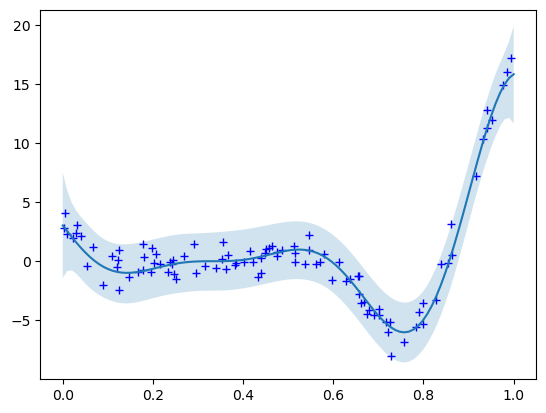

In [35]:
with torch.no_grad():
    ypred, yvar = forward(xtr, ytr, xte, kernel, log_beta)

plt.fill_between(xte.cpu().squeeze().numpy(),
                 ypred.cpu().squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.cpu().squeeze().detach().numpy()),
                 ypred.cpu().squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.cpu().squeeze().detach().numpy()),
                 alpha=0.2, label='95% Confidence interval')
subset_size = 100  # Adjust this to the desired subset size
indices = torch.randperm(xtr.size(0))[:subset_size]

xtr_subset = xtr[indices]
ytr_subset = ytr[indices]

# Move the subset data to CPU for plotting
xtr_subset_cpu = xtr_subset.cpu().numpy()
ytr_subset_cpu = ytr_subset.cpu().numpy()

# Plot the subset of the training data
plt.plot(xtr_subset_cpu, ytr_subset_cpu, 'b+')
plt.plot(xte.cpu(), yte.cpu())
plt.show()

In [37]:
start_time = time.time()
xtr, ytr = xtr.cpu(), ytr.cpu()
model = cigp(xtr, ytr)
model.train_adam(200, 0.1)
end_time = time.time()
standard_gp_time = end_time - start_time

iter 0 nll:5850.84470
iter 10 nll:4855.64257
iter 20 nll:3864.50022
iter 30 nll:2881.83439
iter 40 nll:1923.61515
iter 50 nll:1030.09092
iter 60 nll:296.90970
iter 70 nll:-115.45684
iter 80 nll:-169.68671
iter 90 nll:-154.64654
iter 100 nll:-174.45334
iter 110 nll:-176.20830
iter 120 nll:-175.85972
iter 130 nll:-176.82291
iter 140 nll:-176.81608
iter 150 nll:-176.84050
iter 160 nll:-176.87865
iter 170 nll:-176.87340
iter 180 nll:-176.87817
iter 190 nll:-176.87840


In [38]:
print("standard GP time:", standard_gp_time)
print("CG GP time:", cg_gp_time)

standard GP time: 87.65204405784607
CG GP time: 50.666510820388794
